目的：
1. 绘制 IMU 数据，并左右展示数据
步骤：
1. 导入包
2. 定义路径
3. 编写函数，批量运行

In [37]:
#导入包
import os
import re
import pandas as pd
import matplotlib.pyplot as plt

In [38]:
#确定路径，并切换
path = input("请输入数据的路径")
os.chdir(path)
print("当前路径为：{}".format(os.getcwd()))

当前路径为：/Users/wangshuaibo/Documents/北京悦动/脑卒中项目/阿帅笔记/测试数据及分析结果/20230424鞋垫空放自重漂移测试/RawData


In [39]:
#新建 IMU_plot  文件夹
dir_plot_name = "IMU_plot"

if not os.path.exists(dir_plot_name):
    os.mkdir(dir_plot_name)

if os.path.exists(dir_plot_name):
    print("已经成功新建 IMU_plot")

已经成功新建 IMU_plot


In [40]:
import numpy as np
import pandas as pd
from scipy.spatial.transform import Rotation

def transform_euler_angles(quaternion):
    """
    使用四元数转换欧拉角，并将其转换为特定形式的欧拉角。
    使用阿鲁比小蓝块 IMU 数据进行验证，没有进行鞋垫姿态传感器的验证
    
    Args:
        quaternion (list): 长度为4的Series，表示四元数。
    
    Returns:
        pd.Series: 长度为3的Series，表示经过转换的欧拉角。
    """
    # 使用四元数转换欧拉角
    rotation = Rotation.from_quat(quaternion)
    euler_angles = rotation.as_euler("zyx", degrees=True)
    
    # 将欧拉角转换为特定形式
    # 仅使用 transform 转化，得到的数据不正确，需要进一步转化
    # 第一个角度不需要变化，第二个角度前面加负数，第三个是和180互补加负数
    # 欧拉角的角度范围应该是 -180～180，但是现在数据范围大于 180
    if (euler_angles[2] < 0 or euler_angles[2] == 0).all():
        transformed_angles = np.round([euler_angles[0], -euler_angles[1], 180 + euler_angles[2]], 6)
    else:
        transformed_angles = np.round([euler_angles[0], -euler_angles[1], -(180 - euler_angles[2])], 6)
    
    return pd.Series(transformed_angles)

In [41]:
#确定图片储存的路径以及名称
def plot_IMU_data(path,dir_plot_name,file,start_index,end_index):
    regex = r"(.*)_(.*)_(.*)"
    mysearch = re.search(regex,file)
    if mysearch:
        plot_name = mysearch.group(2) + "-" + dir_plot_name
    path_plot = os.path.join(path,dir_plot_name,plot_name)

    df = pd.read_csv(file)
    euler_cols = ["euler_x","euler_y","euler_z"]
    g_cols = ["gx","gy","gz"]
    a_cols = ["ax","ay","az"]
    q_cols = ["qw","qx","qy","qz"]
    df[euler_cols] = df[q_cols].apply(transform_euler_angles,axis=1)

    df_sel = df.loc[start_index:end_index-1]
    L_data = df_sel[df_sel["part" ]== "L"]
    R_data = df_sel[df_sel["part" ]== "R"]


    #创建一个包含多个子图的 Figure 对象和 AxesSubplot
    fig, axs = plt.subplots(nrows=3, ncols=2,figsize=(12,6))

    #调整子图的位置和大小
    plt.subplots_adjust(wspace=0.2, hspace=0.4)
    fig.set_size_inches(10,8)

    plt.rcParams['font.sans-serif'] = ['Heiti TC', 'SimHei', 'FangSong']  # 汉字字体,优先使用楷体，如果找不到楷体，则使用黑体
    plt.rcParams['font.size'] = 12  # 字体大小
    plt.rcParams['axes.unicode_minus'] = False  # 正常显示负号

    colors=["#db3b26","#54ae32","#48a0f8"]

    yticks = [-180,-90,0,90,180]
    #绘制左右脚数据
    L_data.loc[:,euler_cols].plot(ax=axs[0,0],title="左脚欧拉角数据（°）",color=colors)
    R_data.loc[:,euler_cols].plot(ax=axs[0,1],title="右脚欧拉角数据（°）",color=colors)
    axs[0,0].set_ylim(-180,180)
    axs[0,0].set_yticks(yticks)
    axs[0,1].set_ylim(-180,180)
    axs[0,1].set_yticks(yticks)

    L_data.loc[:,g_cols].plot(ax=axs[1,0],title="左脚角速度数据",color=colors)
    R_data.loc[:,g_cols].plot(ax=axs[1,1],title="右脚角速度数据",color=colors)

    L_data.loc[:,a_cols].plot(ax=axs[2,0],title="左脚加速度数据",color=colors)
    R_data.loc[:,a_cols].plot(ax=axs[2,1],title="右脚加速度数据",color=colors)



    # 添加注释，解释代码的目的和功能
    plt.suptitle(plot_name, fontsize=16)
    fig.text(0.5, 0.02, "时间", ha="center")
    fig.text(0.08, 0.5, "数据值", va="center", rotation="vertical")

    #保存图片
    plt.savefig(path_plot+".png")
    plt.close()

In [42]:

for file in os.listdir(path):
    if ".csv" in file:
        # 默认索引全部数据
        df = pd.read_csv(file)
        end_index = df.shape[0]
        start_index = 0

        #绘图
        plot_IMU_data(path,dir_plot_name,file,start_index,end_index)

In [78]:
# 将数据保存为 html 格式
#确定图片储存的路径以及名称
import mpld3
from mpld3 import plugins
def html_IMU_data(path,dir_plot_name,file,start_index,end_index):
    regex = r"(.*)_(.*)_(.*)"
    mysearch = re.search(regex,file)
    if mysearch:
        plot_name = mysearch.group(2) + "-" + dir_plot_name
    path_plot = os.path.join(path,dir_plot_name,plot_name)

    df = pd.read_csv(file)
    euler_cols = ["euler_x","euler_y","euler_z"]
    g_cols = ["gx","gy","gz"]
    a_cols = ["ax","ay","az"]
    q_cols = ["qw","qx","qy","qz"]
    df[euler_cols] = df[q_cols].apply(transform_euler_angles,axis=1)

    df_sel = df.loc[start_index:end_index-1]
    L_data = df_sel[df_sel["part" ]== "L"]
    R_data = df_sel[df_sel["part" ]== "R"]


    #创建一个包含多个子图的 Figure 对象和 AxesSubplot
    fig, axs = plt.subplots(nrows=3, ncols=2,figsize=(12,6))

    #调整子图的位置和大小
    plt.subplots_adjust(wspace=0.2, hspace=0.4)
    fig.set_size_inches(10,8)

    plt.rcParams['font.sans-serif'] = ['Heiti TC', 'SimHei', 'FangSong']  # 汉字字体,优先使用楷体，如果找不到楷体，则使用黑体
    plt.rcParams['font.size'] = 12  # 字体大小
    plt.rcParams['axes.unicode_minus'] = False  # 正常显示负号

    colors=["#db3b26","#54ae32","#48a0f8"] #设置颜色
    yticks = [-180,-90,0,90,180] #设置大小

    #titles = ["左脚欧拉角（°）","右脚欧拉角（°）","左脚角速度","右脚角速度","左脚加速度(g)","右脚加速度(g)"]

    #绘制左右脚数据
    L_data.loc[:,euler_cols].plot(ax=axs[0,0],title="左脚欧拉角数据（°）",color=colors)
    R_data.loc[:,euler_cols].plot(ax=axs[0,1],title="右脚欧拉角数据（°）",color=colors)
    axs[0,0].set_ylim(-180,180)
    axs[0,0].set_yticks(yticks)
    axs[0,1].set_ylim(-180,180)
    axs[0,1].set_yticks(yticks)

    L_data.loc[:,g_cols].plot(ax=axs[1,0],title="左脚角速度数据",color=colors)
    R_data.loc[:,g_cols].plot(ax=axs[1,1],title="右脚角速度数据",color=colors)

    L_data.loc[:,a_cols].plot(ax=axs[2,0],title="左脚加速度数据",color=colors)
    R_data.loc[:,a_cols].plot(ax=axs[2,1],title="右脚加速度数据",color=colors)



    # 添加注释，解释代码的目的和功能
    plt.suptitle(plot_name, fontsize=16)
    fig.text(0.5, 0.02, "时间", ha="center")
    fig.text(0.08, 0.5, "数据值", va="center", rotation="vertical")

    for axi in axs.flat:
        for axis in [axi.xaxis, axi.yaxis]
            handles, labels = axis.get_legend_handles_labels()
            interactive_legend = plugins.InteractiveLegendPlugin(handles,labels) 
            plugins.connect(fig, interactive_legend,plugins.MousePosition(fontsize=14))
    #保存图片
    mpld3.show_d3() 


SyntaxError: expected ':' (1132240526.py, line 62)


Note: if you're in the IPython notebook, mpld3.show() is not the best command
      to use. Consider using mpld3.display(), or mpld3.enable_notebook().
      See more information at http://mpld3.github.io/quickstart.html .

You must interrupt the kernel to end this command

Serving to http://127.0.0.1:8889/    [Ctrl-C to exit]


127.0.0.1 - - [06/May/2023 18:35:18] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [06/May/2023 18:35:18] "GET /d3.js HTTP/1.1" 200 -
127.0.0.1 - - [06/May/2023 18:35:18] "GET /mpld3.js HTTP/1.1" 200 -
127.0.0.1 - - [06/May/2023 18:35:18] code 404, message Not Found
127.0.0.1 - - [06/May/2023 18:35:18] "GET /apple-touch-icon-precomposed.png HTTP/1.1" 404 -
127.0.0.1 - - [06/May/2023 18:35:18] code 404, message Not Found
127.0.0.1 - - [06/May/2023 18:35:18] "GET /apple-touch-icon.png HTTP/1.1" 404 -



stopping Server...


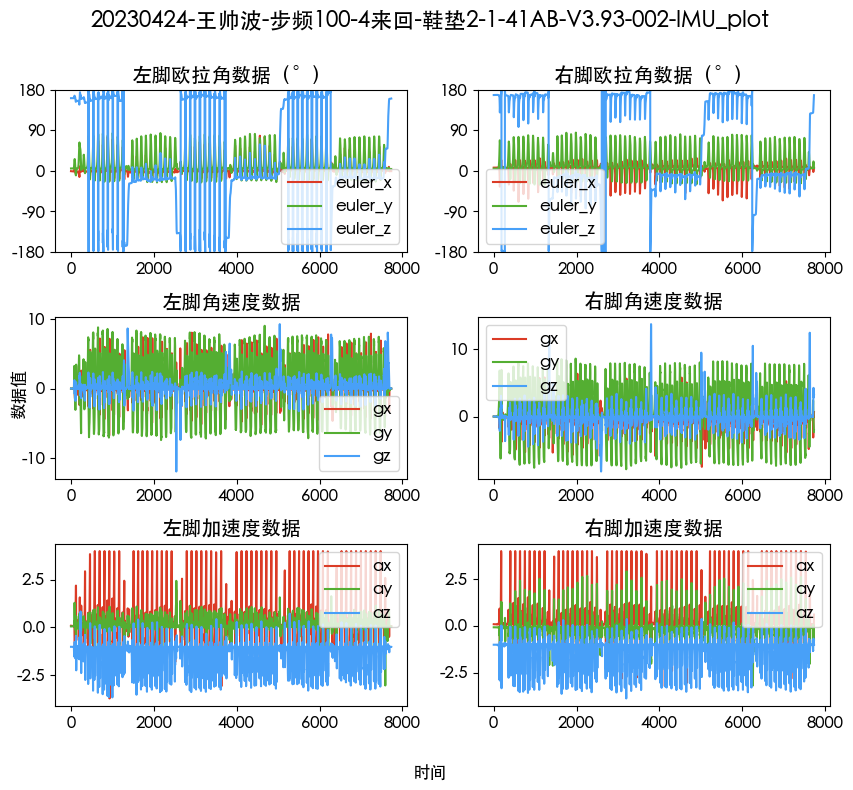

In [79]:

file = "/Users/wangshuaibo/Documents/北京悦动/脑卒中项目/阿帅笔记/测试数据及分析结果/20230424鞋垫空放自重漂移测试/RawData/hwshuai_20230424-王帅波-步频100-4来回-鞋垫2-1-41AB-V3.93-002_202304241804055691.csv"
# 默认索引全部数据
df = pd.read_csv(file)
end_index = df.shape[0]
start_index = 0

#绘图
html_IMU_data(path,dir_plot_name,file,start_index,end_index)

In [64]:
for i in [0,1,2]:
    print(i,i%2)

0 0
1 1
2 0
